In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import albumentations as A
from tqdm import tqdm

from skimage.util import montage 
from skimage.transform import rotate,resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,CSVLogger
import tensorflow.keras.backend as K

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# Data Visualization

In [8]:
# Directories initialization
train_path = '/kaggle/input/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

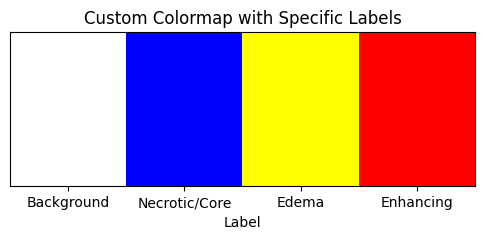

In [9]:
# Custom cmap for our visualizations
# Using matplotlib cmaps did dont allow for distinct separation of tissues (or maybe i couldnt find onethat did)
# bcz they use continuous gradient to smoothly transition between colors
colors = [
    [0, 0, 0, 0],  # Background (fully transparent)
    [0, 0, 1, 1],  # Necrotic/Core (blue)
    [1, 1, 0, 1],  # Edema (yellow)
    [1, 0, 0, 1]   # Enhancing (red)
]

# Create a discrete colormap with these colors
custom_cmap = ListedColormap(colors)

labels = {
    0: 'Background',
    1: 'Necrotic/Core',
    2: 'Edema',
    4: 'Enhancing'  # Note: During training, label 4 is changed to 3
}

# Visualization of the colormap with specific labels
label_indices = list(labels.keys())
label_names = [labels[idx] for idx in label_indices]

label_image = np.array([label_indices])

# Plot the image with the custom colormap
plt.figure(figsize=(6, 2))
plt.imshow(label_image, aspect='auto', cmap=custom_cmap)
plt.yticks([])
plt.xticks(ticks=np.arange(len(label_indices)), labels=label_names)
plt.xlabel('Label')
plt.title('Custom Colormap with Specific Labels')
plt.show()

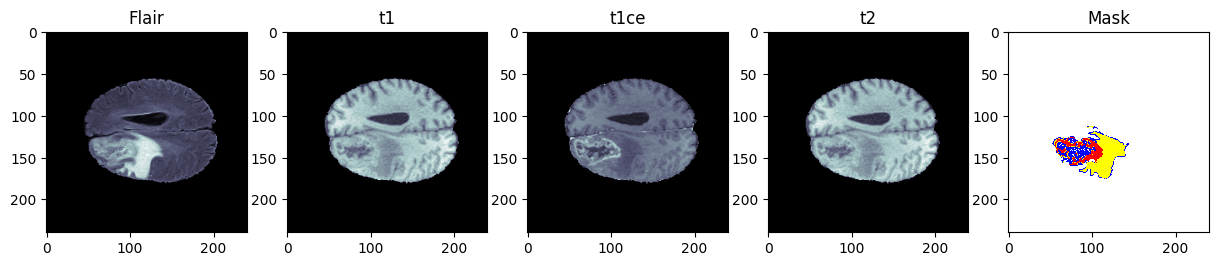

In [10]:
# Visualizing the data

# Loads as a numpy array
test_image_flair=nib.load(train_path + '/BraTS20_Training_006/BraTS20_Training_006_flair.nii').get_fdata()
test_image_t1=nib.load(train_path + '/BraTS20_Training_006/BraTS20_Training_006_t1.nii').get_fdata()
test_image_t1ce=nib.load(train_path + '/BraTS20_Training_006/BraTS20_Training_006_t1ce.nii').get_fdata()
test_image_t2=nib.load(train_path + '/BraTS20_Training_006/BraTS20_Training_006_t1.nii').get_fdata()
test_mask=nib.load(train_path + '/BraTS20_Training_006/BraTS20_Training_006_seg.nii').get_fdata()

n_slice = test_image_flair.shape[0]//2 - 25

plt.figure(figsize=(15, 15))
plt.subplot(151)
plt.imshow(test_image_flair[:,:,n_slice], cmap='bone')
plt.title('Flair')
plt.subplot(152)
plt.imshow(test_image_t1[:,:,n_slice], cmap='bone')
plt.title('t1')
plt.subplot(153)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='bone')
plt.title('t1ce')
plt.subplot(154)
plt.imshow(test_image_t2[:,:,n_slice], cmap='bone')
plt.title('t2')
plt.subplot(155)
plt.imshow(test_mask[:,:,n_slice], cmap = custom_cmap)
plt.title("Mask")
plt.show()

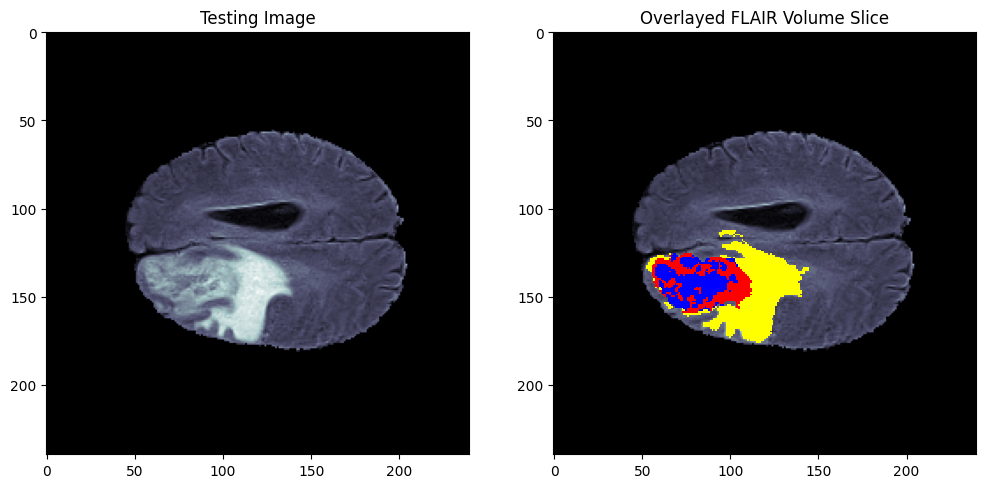

In [11]:
# Overlaying the image with the tumor masking
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('Testing Image')
plt.imshow(test_image_flair[:,:,n_slice], cmap='bone')

plt.subplot(122)
plt.imshow(test_image_flair[:, :, n_slice], cmap='bone')
plt.imshow(test_mask[:, :, n_slice], alpha=1, cmap = custom_cmap, interpolation = "none")
plt.title('Overlayed FLAIR Volume Slice')
plt.show()


# Data Preprocessing

In [12]:
# Testing sizes of the images and masks
print(f"image shape = {test_image_flair.shape} mask shape = {test_mask.shape}")

image shape = (240, 240, 155) mask shape = (240, 240, 155)


In [13]:
def loadimg(imgpath):
    return nib.load(imgpath).get_fdata()


def ccentre(imgslice, x, y):   
    # Tried multiple resize methods .. found cv2 works best
    return cv2.resize(imgslice,(x,y))

def normalizer(imgslice):
    return (imgslice - imgslice.mean()) / imgslice.std()

In [14]:
def pathstoids(dirList):
    x = []
    for i in range(len(dirList)):
        x.append(dirList[i].split("/")[-1])
    return x

# all data directories
all_directories = [f.path for f in os.scandir(train_path) if f.is_dir()]

# This dir has misnaming for the seg file
all_directories.remove(train_path + '/BraTS20_Training_355')
all_ids = pathstoids(all_directories)

print(f"Total = {len(all_ids)} Eg: {all_ids[0]}")

Total = 368 Eg: BraTS20_Training_083


In [15]:
types = ['t1','t1ce','t2','flair','seg']

# Make dirs for each type of data
for tp in types:
    os.makedirs(f'dataset/{tp}', exist_ok = True)

slices_created = 0
imgs = {}
imgslice = {}

for i in tqdm(range(len(all_ids))): # total no of dirs
    current_path = os.path.join(train_path ,all_ids[i])
    
    for tp in types: # seg t1 t1ce t2 flair
        imgs[tp] = loadimg(os.path.join(current_path, f'{all_ids[i]}_{tp}.nii')) # imgs['seg'] = npy for brats20_001_flair.nii
    
    for j in range(155):  # as there 155 instances for each .nii file
        
        for name in imgs: # seg t1 t1ce t2 flair
            imgslice[name] = imgs[name][:, :, j] # imgslice['seg'] = (240 240) of npy for brats20_001_seg.nii
            imgslice[name] = ccentre(imgslice[name], 128, 128) # imgslice['seg'] = (128 128) of npy for brats20_001_seg.nii
        
        # Only takes slices which have masking data
        if imgslice['seg'].max() > 0:
            for name in ['t1','t2','t1ce','flair']:
              imgslice[name] = normalizer(imgslice[name]) # normalize the npy image
            for name in imgslice:
              np.save(f'./dataset/{name}/img_{slices_created}.npy', imgslice[name])
            slices_created += 1


print(f'No of slices : {slices_created}')

100%|██████████| 368/368 [06:56<00:00,  1.13s/it]

No of slices : 24354


In [16]:
IMG_SIZE = 128

# Customized DataGenerator

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, batch_size=32, dim=(IMG_SIZE, IMG_SIZE), n_channels=4, n_classes=4, shuffle=True, augmentation=None):
        self.dim = dim
        self.batch_size = batch_size
        self.list_ids = list_ids
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_ids_temp = [self.list_ids[k] for k in indexes]
        X, y = self.__data_generation(list_ids_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = np.float32)
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype = np.float32)

        for i, ID in enumerate(list_ids_temp):
            images = {}
            for name in ['t1', 't1ce', 't2', 'flair', 'seg']:
                images[name] = np.load(f'dataset/{name}/img_{ID}.npy')

            if self.augmentation:
                augmented = self.augmentation(image=images['flair'], mask=images['seg'])
                images['flair'] = augmented['image']

            X[i,] = np.stack((images['t1'], images['t1ce'], images['t2'], images['flair']), axis=-1)
            images['seg'][images['seg'] == 4] = 3
            y[i,] = to_categorical(images['seg'], num_classes=self.n_classes)
            
        return X, y


In [17]:
# Data Augmentation Configuration
augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=None, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)                  
    ], p=0.8),
    A.RandomBrightnessContrast(p=0.8)
])

# Split the data
list_ids = list(range(slices_created))
train_ids, valid_ids = train_test_split(list_ids, test_size=0.4, random_state=42)
valid_ids, test_ids = train_test_split(valid_ids, test_size=0.5, random_state=42)

print(f'Train : {len(train_ids)} Valid : {len(valid_ids)} Test : {len(test_ids)}')

train_generator = DataGenerator(train_ids, augmentation=augmentation)
valid_generator = DataGenerator(valid_ids, augmentation=None)
test_generator = DataGenerator(test_ids, augmentation=None)

Train : 14612 Valid : 4871 Test : 4871


Text(0.5, 1.0, 'Overlayed Image')

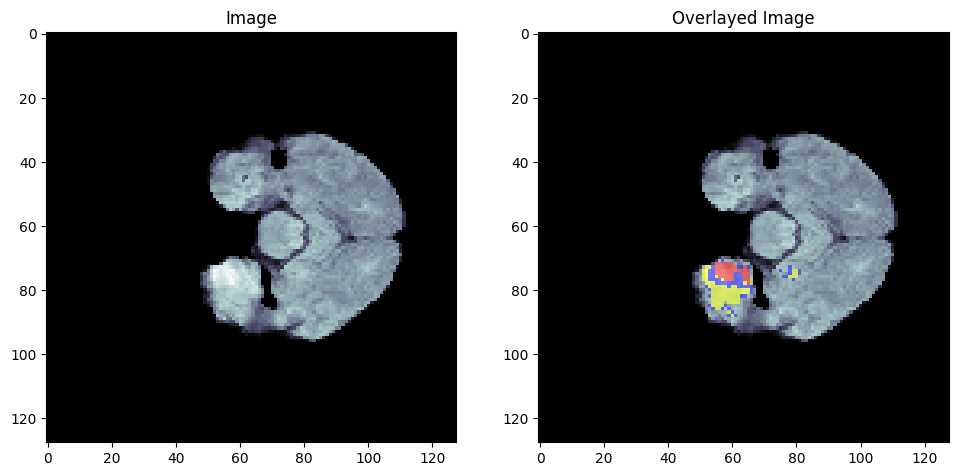

In [18]:
# Testing the generator (Test Gen since it doesnt have augmentations and better visuals)
n_batch = np.random.randint(0,len(test_generator))
a, b = test_generator[n_batch]

n_img = np.random.randint(0,a.shape[0])

plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.imshow(a[n_img, :, :, 3], cmap='bone')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(a[n_img, :, :, 3], cmap='bone')
plt.imshow(np.argmax(b[n_img], axis=-1), alpha=0.5, cmap=custom_cmap)
plt.title('Overlayed Image')


# Model Designing and Training

In [19]:
# For the loss functions
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [20]:
# Determine the dice coeff for each class

def dice_coefficient_each_class(y_true, y_pred, class_index, smooth=1e-6):
    y_true_f = K.flatten(y_true[..., class_index])
    y_pred_f = K.flatten(y_pred[..., class_index])
    
    intersection = K.sum(y_true_f * y_pred_f)
    dice_numerator = 2. * intersection
    dice_denominator = K.sum(y_true_f) + K.sum(y_pred_f)
    
    dice_score = (dice_numerator + smooth) / (dice_denominator + smooth)
    return dice_score

def dice_coefficient_necrotic(y_true, y_pred):
    return dice_coefficient_each_class(y_true, y_pred, class_index=1)

def dice_coefficient_edema(y_true, y_pred):
    return dice_coefficient_each_class(y_true, y_pred, class_index=2)

def dice_coefficient_enhancing(y_true, y_pred):
    return dice_coefficient_each_class(y_true, y_pred, class_index=3)

In [21]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(), dice_coefficient_necrotic,dice_coefficient_edema,dice_coefficient_enhancing]

logger = tf.keras.callbacks.CSVLogger(
    "/kaggle/working/logs.csv", separator=',', append=False
)
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1),
             EarlyStopping(monitor = "val_loss", patience = 10, verbose =1, restore_best_weights = True),
             logger
]


Segmentation Models: using `tf.keras` framework.


In [22]:
BACKBONE = 'resnet50'

model = sm.Unet(BACKBONE,
                classes=4,
                activation='softmax',
                encoder_weights= None,
                input_shape=(128, 128, 4))

model.compile(optimizer=Adam(learning_rate=0.0001), loss= tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)

In [23]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    callbacks= callbacks)

# Save the model
model.save('TumorSegmentation.h5')

Epoch 1/100


I0000 00:00:1724925471.872418     138 service.cc:145] XLA service 0x7af304002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724925471.873258     138 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/456 ━━━━━━━━━━━━━━━━━━━━ 7:34:13 60s/step - dice_coefficient_edema: 0.0269 - dice_coefficient_enhancing: 0.0147 - dice_coefficient_necrotic: 0.0155 - f1-score: 0.0889 - iou_score: 0.0083 - loss: 1.9242

I0000 00:00:1724925500.064751     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 ━━━━━━━━━━━━━━━━━━━━ 180s 265ms/step - dice_coefficient_edema: 0.0508 - dice_coefficient_enhancing: 0.0142 - dice_coefficient_necrotic: 0.0261 - f1-score: 0.1770 - iou_score: 0.1176 - loss: 0.8969 - val_dice_coefficient_edema: 0.1118 - val_dice_coefficient_enhancing: 0.0284 - val_dice_coefficient_necrotic: 0.0503 - val_f1-score: 0.2830 - val_iou_score: 0.2547 - val_loss: 0.1584 - learning_rate: 1.0000e-04
Epoch 2/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - dice_coefficient_edema: 0.2288 - dice_coefficient_enhancing: 0.0772 - dice_coefficient_necrotic: 0.1035 - f1-score: 0.3437 - iou_score: 0.2699 - loss: 0.1048 - val_dice_coefficient_edema: 0.2084 - val_dice_coefficient_enhancing: 0.0843 - val_dice_coefficient_necrotic: 0.0951 - val_f1-score: 0.3421 - val_iou_score: 0.2681 - val_loss: 0.0955 - learning_rate: 1.0000e-04
Epoch 3/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 119s 256ms/step - dice_coefficient_edema: 0.3848 - dice_coefficient_enhancing: 0.1997 - dice_coefficient_necrotic:

# Result Visualization

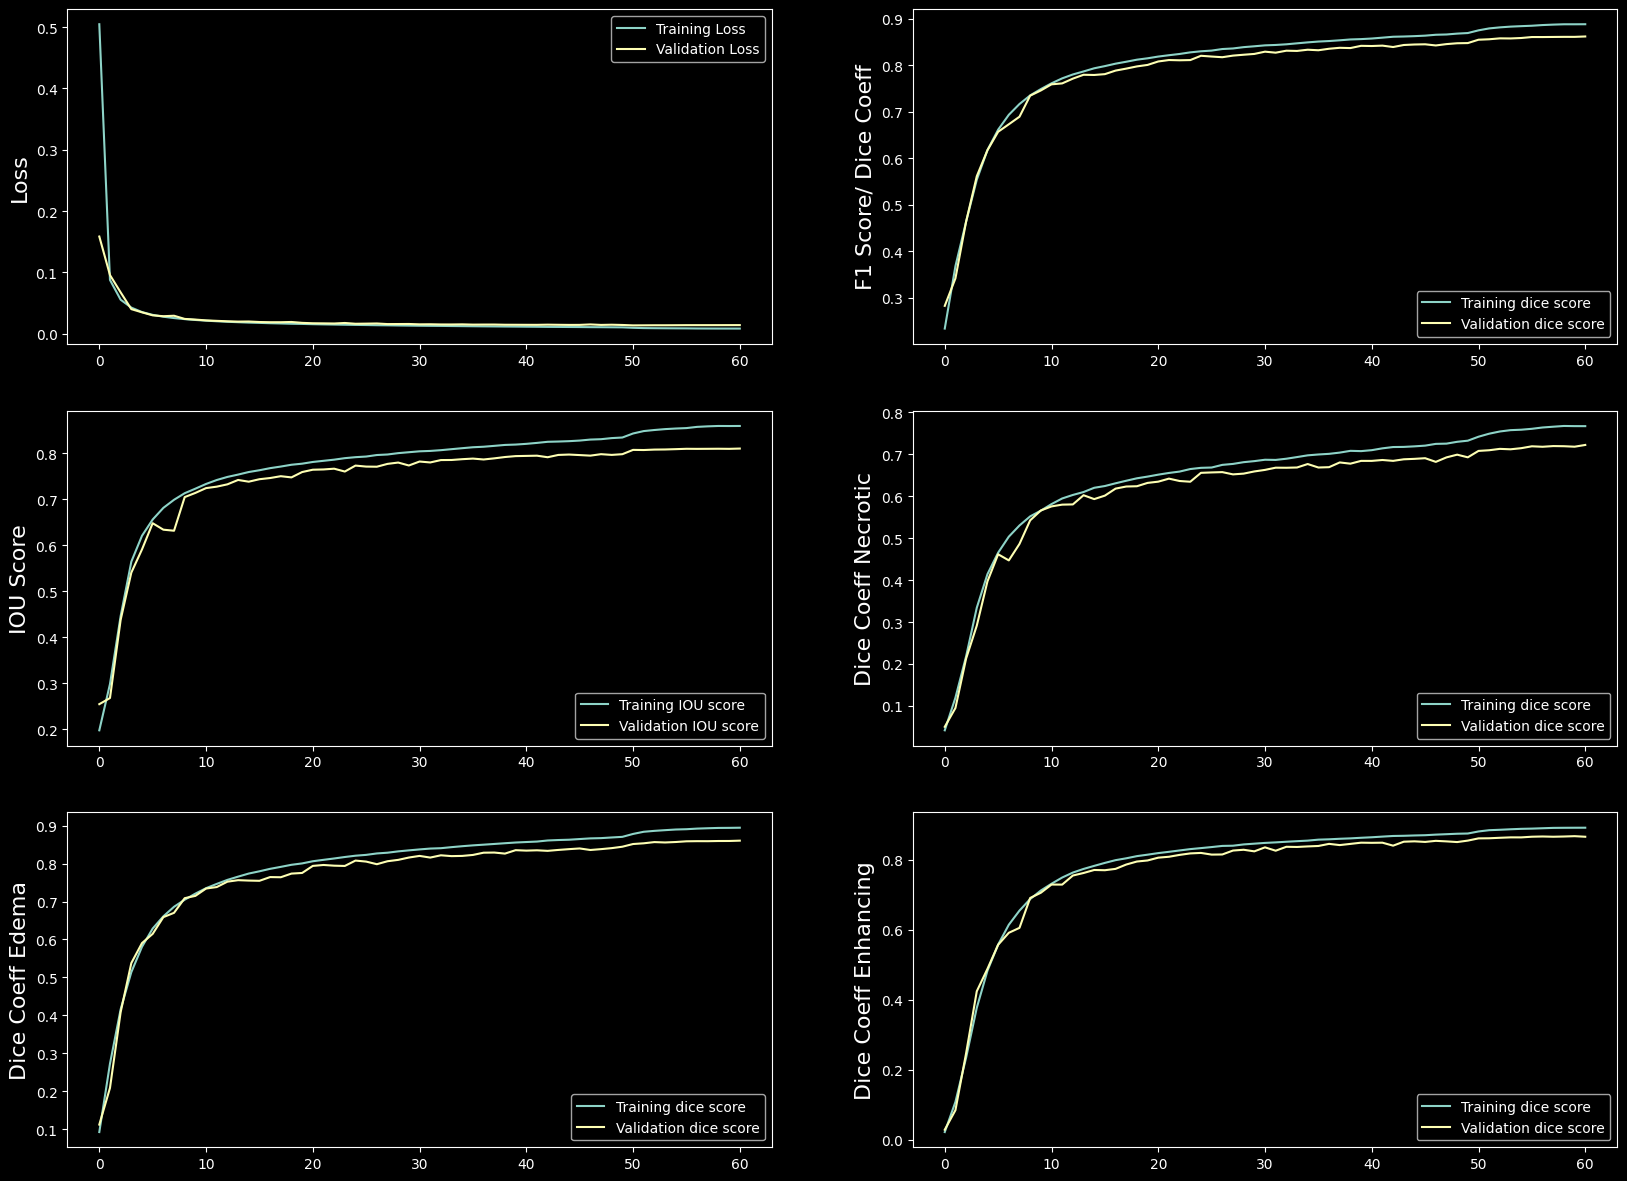

In [24]:
plt.style.use('dark_background')

plt.figure(figsize=(20,20))

plt.subplot(4, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(4, 2, 2)
plt.ylabel('F1 Score/ Dice Coeff', fontsize=16)
plt.plot(history.history['f1-score'], label='Training dice score')
plt.plot(history.history['val_f1-score'], label='Validation dice score')
plt.legend(loc='lower right')

plt.subplot(4, 2, 3)
plt.ylabel('IOU Score', fontsize=16)
plt.plot(history.history['iou_score'], label='Training IOU score')
plt.plot(history.history['val_iou_score'], label='Validation IOU score')
plt.legend(loc='lower right')

plt.subplot(4, 2, 4)
plt.ylabel('Dice Coeff Necrotic', fontsize=16)
plt.plot(history.history['dice_coefficient_necrotic'], label='Training dice score')
plt.plot(history.history['val_dice_coefficient_necrotic'], label='Validation dice score')
plt.legend(loc='lower right')

plt.subplot(4, 2, 5)
plt.ylabel('Dice Coeff Edema', fontsize=16)
plt.plot(history.history['dice_coefficient_edema'], label='Training dice score')
plt.plot(history.history['val_dice_coefficient_edema'], label='Validation dice score')
plt.legend(loc='lower right')

plt.subplot(4, 2, 6)
plt.ylabel('Dice Coeff Enhancing', fontsize=16)
plt.plot(history.history['dice_coefficient_enhancing'], label='Training dice score')
plt.plot(history.history['val_dice_coefficient_enhancing'], label='Validation dice score')
plt.legend(loc='lower right')

plt.show()

In [25]:
model.evaluate(test_generator, verbose=2)

152/152 - 27s - 177ms/step - dice_coefficient_edema: 0.8549 - dice_coefficient_enhancing: 0.8581 - dice_coefficient_necrotic: 0.7124 - f1-score: 0.8560 - iou_score: 0.8090 - loss: 0.0136


[0.013595395721495152,
 0.8089651465415955,
 0.8559554219245911,
 0.7123791575431824,
 0.8548874855041504,
 0.8581315875053406]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


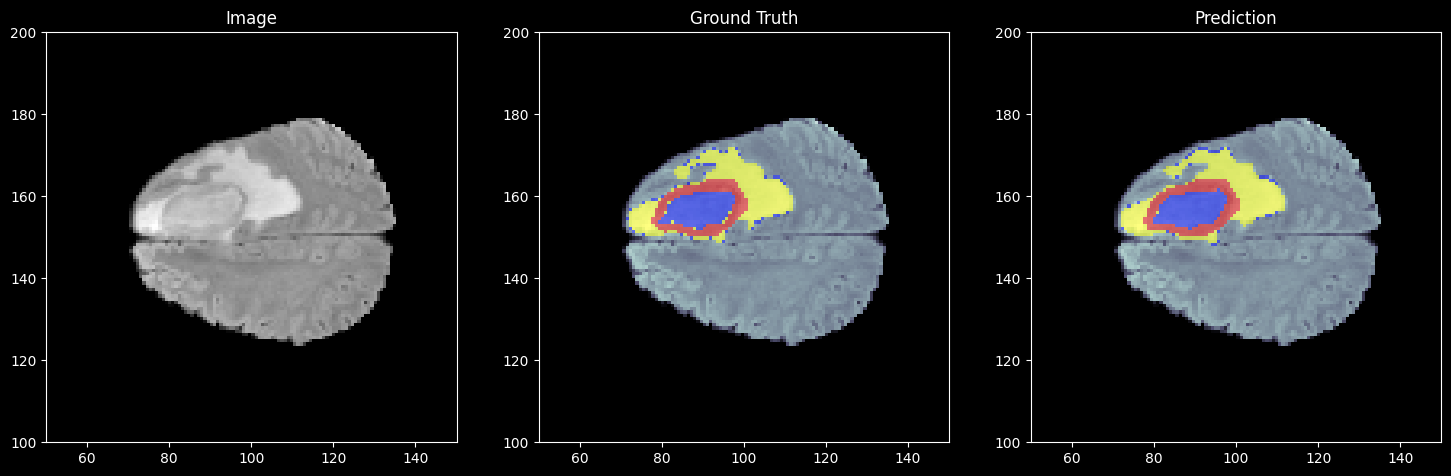

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


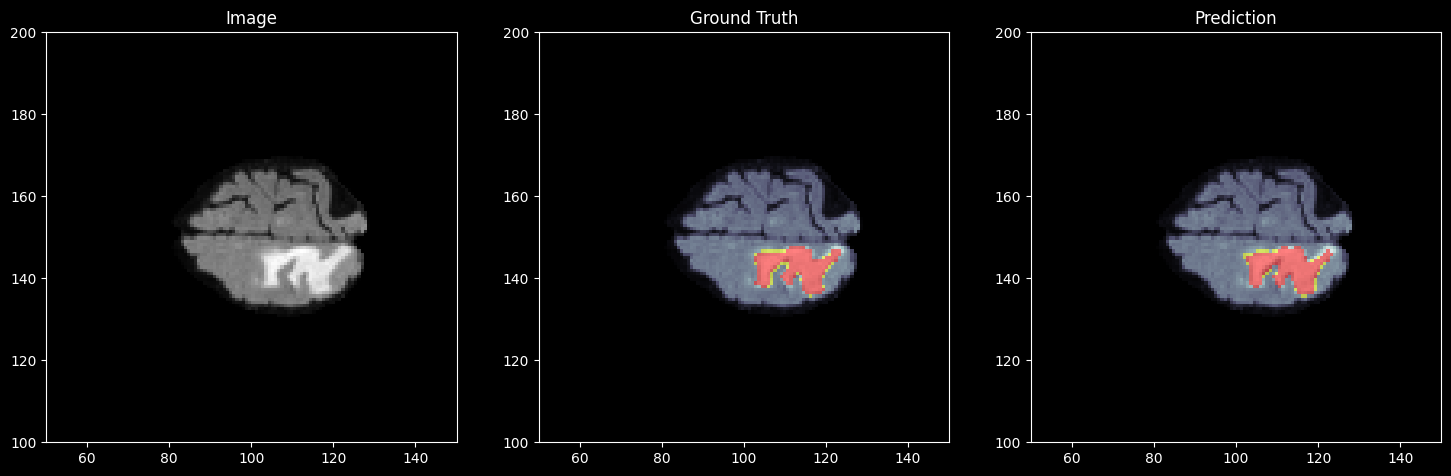

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


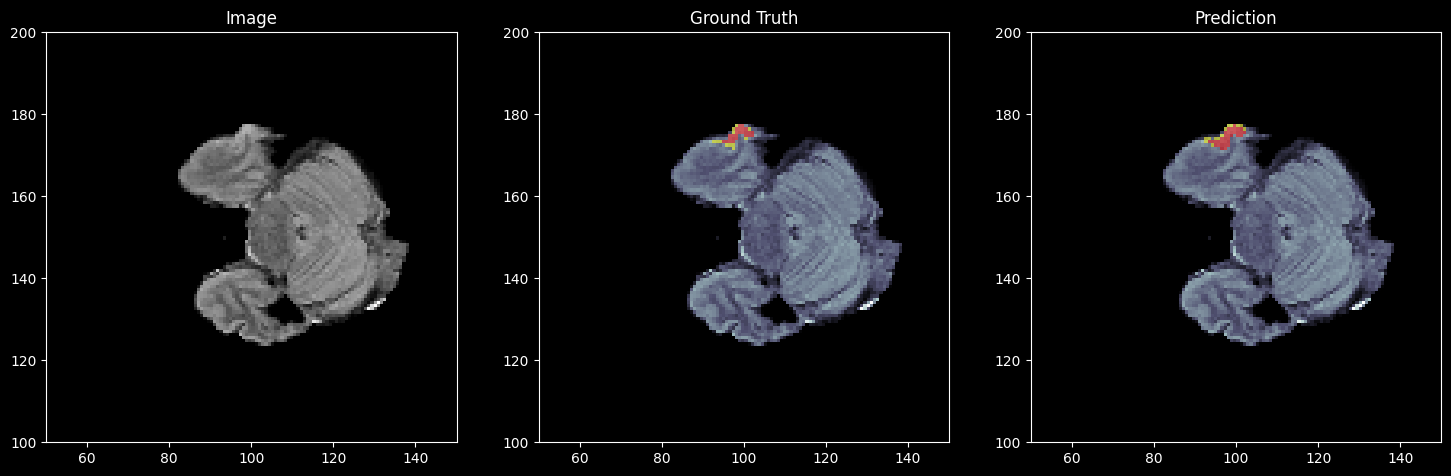

In [38]:
for i in range(3):
    n_batch = np.random.randint(0,len(test_generator))
    a, b = test_generator[n_batch]
    pred = model.predict(a)
    n_img = np.random.randint(0,a.shape[0])

    # Example zoom region (xmin, xmax, ymin, ymax)
    zoom_region = (50, 150, 100, 200)

    plt.figure(figsize=(18, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(a[n_img, :, :, 3], cmap='gray', extent=zoom_region)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(a[n_img, :, :, 3], cmap='bone', extent=zoom_region)
    plt.imshow(np.argmax(b[n_img], axis=-1), alpha=0.5, cmap=custom_cmap, extent = zoom_region)
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(a[n_img, :, :, 3], cmap='bone', extent=zoom_region)
    plt.imshow(np.argmax(pred[n_img], axis=-1), alpha=0.5, cmap=custom_cmap, extent = zoom_region)
    plt.title('Prediction')

    plt.show()